### Isolation Forest for Time-Series Anomaly Detection
Twitter Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import moment, skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle 

#### Data preprocessing

In [2]:
raw_dt = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv")
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,value
0,2015-02-26 21:42:53,11
1,2015-02-26 21:47:53,10
2,2015-02-26 21:52:53,3
3,2015-02-26 21:57:53,4
4,2015-02-26 22:02:53,9
...,...,...
15897,2015-04-23 02:27:53,1
15898,2015-04-23 02:32:53,4
15899,2015-04-23 02:37:53,3
15900,2015-04-23 02:42:53,8


Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [3]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal

# Access the lists
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)
#Change according to ds: [0] = machine_temperature, [1] = twitter_volume , [2] = nyc_taxi
instances_of_anomaly_twitter = lists[1]        

# Marking the instances of anomaly in the dataset
for instance in instances_of_anomaly_twitter: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Plot the data with anomalies marked

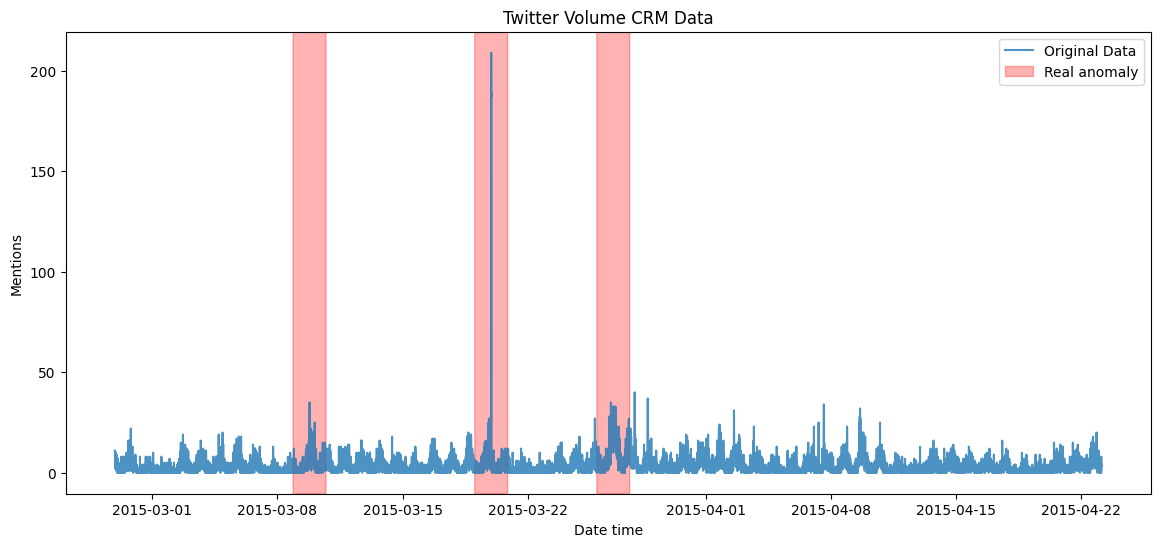

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], label='Original Data', alpha=0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
plt.title('Twitter Volume CRM Data')
plt.xlabel('Date time')
plt.ylabel('Mentions')
plt.legend()
plt.show()

#### Split data into training, validation and testing sets
55% training, 20% validation and 25% testing

In [54]:
#Split up for twitter dataset
data_train = data[int(len(data)*0.4):]
data_val = data[int(len(data)*0.25):int(len(data)*0.4)]
data_test = data[:int(len(data)*0.25)]

labels_train = data_train['anomaly']
labels_val = data_val['anomaly']
labels_test = data_test['anomaly']

X_train = data_train.drop(['anomaly'], axis=1)
X_val = data_val.drop(['anomaly'], axis=1)
X_test = data_test.drop(['anomaly'], axis=1)

contamination_coef = sum(labels_train) / len(labels_train)

Normalize the data according to the training set

In [55]:
mean = X_train['value'].mean()
std = X_train['value'].std()
X_train['value'] = (X_train['value'] - mean) / std
X_val['value'] = (X_val['value'] - mean) / std
X_test['value'] = (X_test['value'] - mean) / std

#### Model

Extract features from time series data

In [56]:
def extract_features(time_series, window_size):
    features = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i:i+window_size]
        mean = np.mean(window)
        std_dev = np.std(window)
        skewness = moment(window, moment=3)
        kurtosis_val = moment(window, moment=4)
        autocorr_lag1 = acf(window, fft=False)[1]  # Autocorrelation at lag 1
        fourier_coeffs = np.abs(fft(window))[:window_size//2]  # Fourier transform coefficients (amplitudes) 
        
        feature_vector = [mean, std_dev, skewness, kurtosis_val , autocorr_lag1]
        feature_vector.extend(fourier_coeffs)
        
        features.append(feature_vector)
    
    return np.array(features)

In [57]:
window_size = 288  # 1 day
X_train_features = extract_features(np.array(X_train['value']), window_size)
X_val_features = extract_features(np.array(X_val['value']), window_size)
X_test_features = extract_features(np.array(X_test['value']), window_size)

In [58]:
(X_train_features.shape, X_val_features.shape, X_test_features.shape)

((9255, 149), (2098, 149), (3688, 149))

Train Isolation Forest model

Contamination parameter sets the proportion of anomalies expected in the data

In [59]:
model = IsolationForest(contamination=contamination_coef)
model.fit(X_train_features)

IsolationForest(contamination=0.05564871096206246)

In [60]:
# Predict anomaly scores
anomaly_scores = model.decision_function(X_val_features)

In [61]:
# Threshold for classifying instances as anomalies
# Bottom 1% of scores, since output of decision_function is between [-1, 1] with -1 being the most anomalous
threshold = np.percentile(anomaly_scores, 1)
print(threshold)

-0.19599190402580735


In [62]:
# Compute the anomaly scores for the test set
test_scores = model.decision_function(X_test_features)

In [63]:
# Classify instances as normal (0) or anomalous (1)
val_predictions = np.where(anomaly_scores <= threshold, 1, 0)
test_predictions = np.where(test_scores <= threshold, 1, 0)

In [64]:
def assign_point_predictions(window_predictions, window_size):
    point_predictions = np.append(np.full((window_size-1)//2, window_predictions[0]), window_predictions)
    point_predictions = np.append(point_predictions, np.full((window_size-1)//2+1, window_predictions[-1]))
    return point_predictions

In [65]:
val_point_predictions = assign_point_predictions(val_predictions, window_size)
test_point_predictions = assign_point_predictions(test_predictions, window_size)

In [66]:
# Validation set output predictions
print("Predictions:", val_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_val, val_point_predictions)
conf_matrix = confusion_matrix(labels_val, val_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.7861635220125787
Confusion Matrix:
[[1854    0]
 [ 510   21]]


In [67]:
# Test set output predictions
print("Predictions:", test_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_test, test_point_predictions)
conf_matrix = confusion_matrix(labels_test, test_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.8664150943396226
Confusion Matrix:
[[3444    0]
 [ 531    0]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, test_point_predictions))

In [68]:
len(labels_test), len(test_point_predictions), len(test_predictions)

(3975, 3975, 3688)

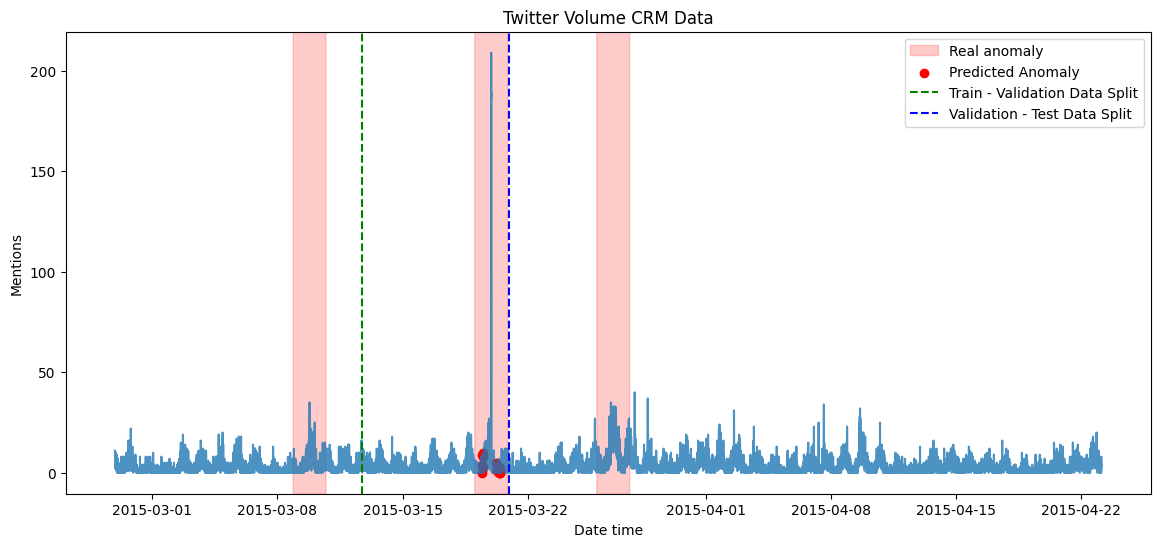

In [69]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], alpha= 0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.2, transform=ax.get_xaxis_transform(),label='Real anomaly')
ax.scatter(data_val['timestamp'][val_point_predictions == 1], data_val['value'][val_point_predictions == 1], color='red', label='Predicted Anomaly')
ax.scatter(data_test['timestamp'][test_point_predictions == 1], data_test['value'][test_point_predictions == 1], color='red')
plt.title('Twitter Volume CRM Data')
plt.xlabel('Date time')
plt.ylabel('Mentions')
ax.axvline(data_val['timestamp'].iloc[0], color='green', linestyle='--', label='Train - Validation Data Split')
ax.axvline(data_val['timestamp'].iloc[-1], color='blue', linestyle='--', label='Validation - Test Data Split')
plt.legend()
plt.show()